<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Quantum State Tomography*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorial.

***
### Contributors
Christopher J. Wood$^{1}$ and Jay M. Gambetta$^{1}$

1. IBM T.J. Watson Research Center, Yorktown Heights, NY, USA

## Introduction

In this notebook we demonstrate how to design and run experiments to perform quantum state tomography using Qiskit, and demonstrate this using both simulators and the IBM Q Experience hardware. 

The functions used in this notebook to implement state tomography may be imported from the `qiskit.tools.qcvv.tomography` module.

#### Experiment Design

The tomography experiments demonstrated in this notebook append a state preparation circuit with measurements of all qubits in each of the X, Y, and Z Pauli bases. For $n$-qubits this gives a total of $3^n$ measurement circuits which must be run, and the resulting counts for the $6^n$ measurement outcomes across all circuits give a tomographically overcomplete basis for reconstruction of the quantum state.

#### State Reconstruction Methods

State reconstruction may be done using a variety of methods. In this notebook we implement two simple cases: 
* Linear Inversion
* Fast maximum likelihood (*see [J Smolin, JM Gambetta, G Smith, Phys. Rev. Lett. 108, 070502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.070502), open access: [arXiv:1106.5458](https://arxiv.org/abs/1106.5458)*).

In [12]:
import numpy as np
from time import sleep  # used for polling jobs
    
# importing the QISKit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import register, execute, least_busy, available_backends, get_backend

# import tomography library
import qiskit.tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state, plot_histogram
from qiskit.tools.qi.qi import state_fidelity, concurrence, purity, outer
from qiskit.wrapper.jupyter import *

In [1]:
import sys, getpass
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
    print('Qconfig loaded from %s.' % Qconfig.__file__)
except:
    APItoken = getpass.getpass('Please input your token and hit enter: ')
    qx_config = {
        "APItoken": APItoken,
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    print('Qconfig.py not found in qiskit-tutorial directory; Qconfig loaded using user input.')

Qconfig loaded from ../../Qconfig.py.


## State tomography of an entangled Bell-state

We will demonstrate preparation, measurement, and tomographic reconstruction of a 2-qubit Bell state $\frac{1}{\sqrt2}\left(|00\rangle+|11\rangle\right)$.

### State preparation

We begin with constructing a circuit to prepare the target state. This circuit requires a 2-qubit quantum register, and a 2-bit classical register to store measurement outcomes.

In [3]:
# Create a 2-qubit quantum register
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

# quantum circuit to make an entangled Bell state 
bell_circ = QuantumCircuit(qr, cr, name='bell')
bell_circ.h(qr[1])
bell_circ.cx(qr[1], qr[0])

#### Visualization of the ideal state

Before we perform tomographic measurement, we will visualize the ideal output state for the preparation circuit. We may obtain the final state-vector by executing the circuit on the `"local_statevector_simulator"` backend:

In [4]:
job = execute(bell_circ, backend='local_statevector_simulator')
bell_psi = job.result().get_statevector(bell_circ)
bell_rho = outer(bell_psi) # construct the density matrix from the state vector

We may visualize the final state using the `plot_state` function. By default this creates a *city plot*, which is a 2D-bar plot of real and imaginary matrix elements of a density matrix $\rho$. Here, we instead ask it to plot the Pauli state vector.

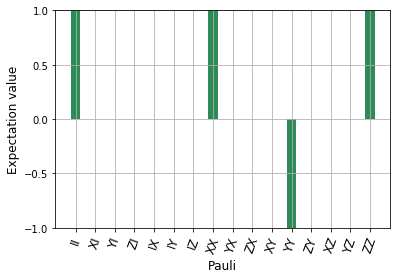

In [5]:
# plot the state
plot_state(bell_rho,'paulivec')

We can compare the ideal entangled state to a non-entangled mixed state $\frac{1}{2}(|00\rangle\langle00| +|11\rangle\langle11|)$:

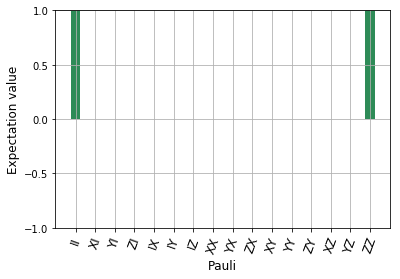

In [6]:
rho_mixed = np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])/2
plot_state(rho_mixed, 'paulivec')

### Building tomography measurement circuits

Next we must construct a family of circuits that implements a tomographically complete set of measurements of the qubit. The **`qiskit.tools.qcvv.tomography`** module contains functions to generate these measurement circuits for general n-qubit systems. 

#### Specifying the measured qubits and measurement basis

A state tomography experiment is specified by a **`state_tomography_set`** object: 
```python
tomo_set = tomo.state_tomography_set(qubits, meas_basis)
```
where
- `qubits` is a list of the qubit indexes within a register (eg. [0, 1] for the first 2 qubits)
- `meas_basis` is the basis to measure each qubit in. The default value is `meas_basis='Pauli'`.

This contains information about which qubits are to be measured, and in what basis. The default option is to measure each single qubit in the X, Y, and Z bases.  This results in $3^n$ measurement circuits that must be executed to gather count statistics for the tomographic reconstruction.

#### Adding measurement circuits to a Quantum Program

Once a state tomography set has been defined, the function to append the tomography circuits to a `QuantumProgram` is:
```python
tomo_circuits = tomo.create_tomography_circuits(circuit, qr, cr, tomo_set)
```
where 
- `circuit` is the preparation circuit `'name'`, to be appended with measurements.
- `qr` is the quantum register contained in `circuit` to be measured.
- `cr` is the classical register in `circuit` to store the measurement results. 
- `tomo_set` is a `state_tomography_set`, the dict of tomography configurations.

The function output `tomo_circuits` is a list of quantum tomography circuits used to execute the tomography experiments. The measured qubits will be `qr[j]`, with corresponding measurement outcomes stored in classical bits `cr[j]`, where `j` corresponds to each qubit in the state tomography set.

In [7]:
# Construct state tomography set for measurement of qubits [0, 1] in the Pauli basis
bell_tomo_set = tomo.state_tomography_set([0, 1])

# Add the state tomography measurement circuits to the Quantum Program
bell_tomo_circuits = tomo.create_tomography_circuits(bell_circ, qr, cr, bell_tomo_set)

print('Created State tomography circuits:')
for circ in bell_tomo_circuits:
    print(circ.name)

Created State tomography circuits:
bell_meas_X(0)X(1)
bell_meas_X(0)Y(1)
bell_meas_X(0)Z(1)
bell_meas_Y(0)X(1)
bell_meas_Y(0)Y(1)
bell_meas_Y(0)Z(1)
bell_meas_Z(0)X(1)
bell_meas_Z(0)Y(1)
bell_meas_Z(0)Z(1)


### Testing experiments on a simulator

Now that we have prepared the required circuits for state preparation and measurement, we should test them on a simulator before trying to run them on the real device.

We specify the device, and a number of experiment shots to perform to gather measurement statistics. The larger the number of shots, the more accurate our measurement probabilities will be compared to the *true* value.

In [8]:
# Use the local simulator
backend = 'local_qasm_simulator'

# Take 5000 shots for each measurement basis
shots = 5000

# Run the simulation
bell_tomo_job = execute(bell_tomo_circuits, backend=backend, shots=shots)
bell_tomo_result = bell_tomo_job.result()
print(bell_tomo_result)

COMPLETED


### Extracting tomography data from results

Next we extract the tomography data from the output results using:
```python
data = tomo.tomography_data(results, 'name', state_tomo_set)
```
where
- `results` is the Result object returned from execution of `state_tomo_set` circuits.
- `name` is the name of the original circuit used to generate tomography data.
- `state_tomo_set` is the tomography set used for generation of tomography data.

This returns a dictionary that stores the measurement basis, and measured counts along with measurement basis configuration corresponding to each outcome.

In [9]:
bell_tomo_data = tomo.tomography_data(bell_tomo_result, bell_circ.name, bell_tomo_set)

### Reconstructing state from count data

To reconstruct the maximum likelihood estimate of the measured quantum state, we use the following function:
```
tomo.fit_tomography_data(tomo_data, method, options)
```
where
- `QP` is the quantum program containing the measurement results
- `circuits` is the array of tomographic measurement circuits measured
- `shots` is the total number of shots for each measurement circuit
- `total_qubits` is the total number of qubits in the system (the length of shot outcome bitstrings)
- `meas_qubits` is an array of the measurement qubit indices

In [10]:
rho_fit = tomo.fit_tomography_data(bell_tomo_data)

We can compare the reconstructed state to the target state vector. We use the Fidelity function, which for comparing a density matrix $\rho$ to a pure state $|\psi\rangle$ is given by $F = \sqrt{\langle \psi| \rho |\psi\rangle}$. This may be done by the function **`state_fidelity`** from the **`qiskit.tools.qi`** module.

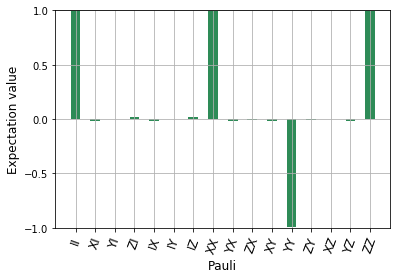

Fidelity = 0.9975291228857819
concurrence =  0.8805791360921791
purity =  0.9955494990339162


In [11]:
# calculate fidelity, concurrence and purity of fitted state
F_fit = state_fidelity(rho_fit, bell_psi)
con = concurrence(rho_fit)
pur = purity(rho_fit)

# plot 
plot_state(rho_fit, 'paulivec')
print('Fidelity =', F_fit)
print('concurrence = ', str(con))
print('purity = ', str(pur))

Note that since our simulator is *perfect*, the output state should be *exactly* the Bell state, so we should obtain F = 1. Why is it not, in our case? Since we can never directly *see* the final state, we must obtain information about it via measurements. We would only obtain the *true* probabilities for the state in the limit of infinite measurement shots. Hence, we have statistical error in our reconstruction from imperfect information about the state itself. Try running with a different number of shots on the simulator and see how it affects the fidelity of the reconstruction.

### Running on a real device

Now that we've checked that our simple tomography experiment worked, let's try it out on the IBM Quantum Experience! To do this, we must attach our API key, and it is good practice to set a limit on the number of credits to use:

In [13]:
%%qiskit_job_status
# Register API token for online backends
register(qx_config['APItoken'], qx_config['url'])

# Use the IBM Quantum Experience (choose least busy device)
backend = least_busy(available_backends())

# Take 1000 shots for each measurement basis
# Note: reduce this number for larger number of qubits
shots = 1000
# set max credits to spend
max_credits = 8

# Run the experiment
job_on_device = execute(bell_tomo_circuits, backend=backend, shots=shots, max_credits=max_credits)

You can monitor the status of you job, and ask for the result.

Note: a call to `job.result()` blocks until the job execution is done and result is available.

In [14]:
# Wait for the result and get it when ready
bell_tomo_result_device = job_on_device.result()

As before, we can extract the tomography data and reconstruct the measured density matrix for the 2-qubit Bell state prepared by our test circuit

In [15]:
bell_tomo_data = tomo.tomography_data(bell_tomo_result_device, 'bell', bell_tomo_set)

# Reconstruct experimentally measured density matrix 
rho_fit_real = tomo.fit_tomography_data(bell_tomo_data)

Finally, we compare the fidelity of the experimentally measured state to the ideal state. Notice that the fidelity is lower than for the simulation. This is because in a real experiment, there is not only the statistical error in the reconstruction, but also experimental error in the device when implementing the gates in the preparation and measurement circuits, as well as error in the measurements themselves.

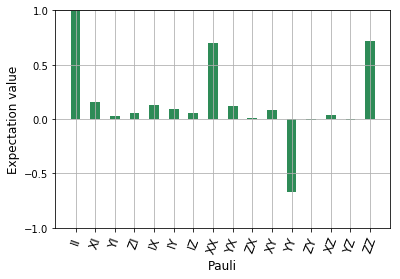

Fidelity with ideal state
F = 0.7735592570691807
concurrence =  0.4435698973682888
purity =  0.6363623588488492


In [16]:
F_fit_real = state_fidelity(rho_fit_real, bell_psi)
plot_state(rho_fit_real, 'paulivec')
print('Fidelity with ideal state')
print('F =', F_fit_real)

# calculate concurrence and purity
con = concurrence(rho_fit_real)
pur = purity(rho_fit_real)
print('concurrence = ', str(con))
print('purity = ', str(pur))